In [1]:
import pandas as pd
from sqlalchemy import create_engine

# Extract

## Read the data from SQL Database

This section won't be run the first time. At the end of this notebook we load the transformed data into a SQL database, this section reads from that database and gets the fully transformed companies_df dataframe ready to do analysis on it again. 

In [2]:
from postgres_login import username, password, connection

connection_string = connection_string = f"{username}:{password}@localhost:{connection}/project2"
engine = create_engine(f'postgresql://{connection_string}')

In [3]:
companies_df = pd.read_sql_query("select * from company_data", con=engine, index_col="employee_id")

In [4]:
companies_df

,environment_satisfaction,job_satisfaction,work_life_balance,job_involvement,performance_rating,num_companies_worked,attrition,percent_salary_hike
employee_id,,,,,,,,
1,3,4,2,3,3,1,No,11
2,3,2,4,2,4,0,Yes,23
3,2,2,1,3,3,1,No,15
4,4,4,3,2,3,3,No,11
5,4,1,3,3,3,4,No,12
...,...,...,...,...,...,...,...,...
4405,3,4,3,2,3,1,No,18
4406,4,1,3,3,3,3,No,17
4407,4,4,3,2,3,2,No,15


## Read data from the CSV files

In [5]:
general_data = "./resources/general_data.csv"
employee_survey = "./resources/employee_survey_data.csv"
manager_survey = "./resources/manager_survey_data.csv"

general_df = pd.read_csv(general_data)
employee_df = pd.read_csv(employee_survey)
manager_df = pd.read_csv(manager_survey)

# Transform

We want to see how often and why workers change jobs. By looking at the effect that subjective measures like job performance
and job satisfaction or financial incentives such as salary increases we hope to predict wheather an employee will stay, or move on. 

In [6]:
# EmployeeID is shared by all of the datasets so we set them as the index and join on them later.

general_df = general_df.set_index("EmployeeID")
employee_df = employee_df.set_index("EmployeeID")
manager_df = manager_df.set_index("EmployeeID")

In [7]:
# The employee dataframe contains self reported information about employees regarding job satisfaction
# The manager dataframe contains information on employee performance as determined by a manager.

# We join both of the dataframes together on EmployeeID.

companies_df = employee_df.join(manager_df)

In [8]:
# From the general employee dataset we want to pull "Attrition" and "NumCompaniesWorked" to answer our question about
# workers leaving the company. We alse grab "PercentSalaryHike" to answer our question about financial incentives.

companies_df = companies_df.join(general_df[["NumCompaniesWorked", "Attrition", "PercentSalaryHike"]], on="EmployeeID")

In [9]:
# Some rows are missing data, so we drop them in order to ensure that we have a complete picture.

companies_df = companies_df.dropna()

In [10]:
companies_df

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,NumCompaniesWorked,Attrition,PercentSalaryHike
EmployeeID,,,,,,,,
1,3.0,4.0,2.0,3,3,1.0,No,11
2,3.0,2.0,4.0,2,4,0.0,Yes,23
3,2.0,2.0,1.0,3,3,1.0,No,15
4,4.0,4.0,3.0,2,3,3.0,No,11
5,4.0,1.0,3.0,3,3,4.0,No,12
...,...,...,...,...,...,...,...,...
4405,3.0,4.0,3.0,2,3,1.0,No,18
4406,4.0,1.0,3.0,3,3,3.0,No,17
4407,4.0,4.0,3.0,2,3,2.0,No,15


In [11]:
# Double check the counts to make sure that all columns are filled.

companies_df.count()

EnvironmentSatisfaction    4308
JobSatisfaction            4308
WorkLifeBalance            4308
JobInvolvement             4308
PerformanceRating          4308
NumCompaniesWorked         4308
Attrition                  4308
PercentSalaryHike          4308
dtype: int64

In [12]:
# Even though we have only whole numbers in the dataframe, some are considered floats and others int64.

print(companies_df.dtypes)

EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
JobInvolvement               int64
PerformanceRating            int64
NumCompaniesWorked         float64
Attrition                   object
PercentSalaryHike            int64
dtype: object


In [13]:
# In order to make the database cleaner and save space we convert everything int32.

companies_df = companies_df.astype({
    "EnvironmentSatisfaction":"int32",
    "JobSatisfaction":"int32",
    "WorkLifeBalance":"int32",
    "JobInvolvement":"int32",
    "PerformanceRating":"int32",
    "NumCompaniesWorked":"int32",
    "PercentSalaryHike":"int32"   
})

print(companies_df.dtypes)

EnvironmentSatisfaction     int32
JobSatisfaction             int32
WorkLifeBalance             int32
JobInvolvement              int32
PerformanceRating           int32
NumCompaniesWorked          int32
Attrition                  object
PercentSalaryHike           int32
dtype: object


In [14]:
# We noticed that when making queries in SQL, columns with capilization needed to be surrounded with quotation marks
# this is a bit tedious to do, so in order to make working with this dataset in SQL easier and more readable we rename
# all the columns to be in snake case, lowercase with underscores seperating words.

companies_df.rename(columns={
    "EnvironmentSatisfaction":"environment_satisfaction",
    "JobSatisfaction":"job_satisfaction",
    "WorkLifeBalance":"work_life_balance",
    "JobInvolvement":"job_involvement",
    "PerformanceRating":"performance_rating",
    "NumCompaniesWorked":"num_companies_worked",
    "Attrition":"attrition",
    "PercentSalaryHike":"percent_salary_hike"
}, inplace=True)

companies_df.index.names = ["employee_id"]

## Analysis 

,num_companies_worked
attrition,
No,2.644697
Yes,2.938307


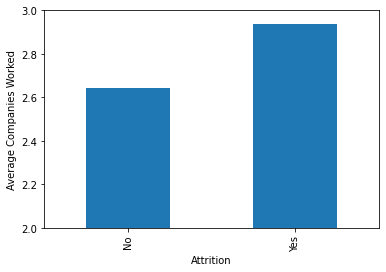

In [15]:
# We can see here that employees that attrit (quit) work for more companies on average.

companies_df[["attrition", "num_companies_worked"]].groupby("attrition").mean().plot(kind="bar", legend=False, ylabel="Average Companies Worked", xlabel="Attrition", ylim=[2,3])
companies_df[["attrition", "num_companies_worked"]].groupby("attrition").mean()

,job_satisfaction
attrition,
No,2.775408
Yes,2.466284


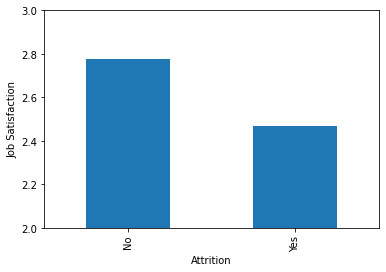

In [16]:
# Employees that quit show lower job satisfaction.

companies_df[["attrition", "job_satisfaction"]].groupby("attrition").mean().plot(kind="bar", legend=False, ylabel="Job Satisfaction", xlabel="Attrition", ylim=[2,3])
companies_df[["attrition", "job_satisfaction"]].groupby("attrition").mean()

,work_life_balance
attrition,
No,2.780116
Yes,2.665710


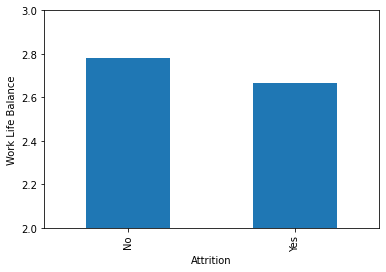

In [17]:
# Employees that quit report a lower work/life balance, although the difference is not as great as job satisfaction.

companies_df[["attrition", "work_life_balance"]].groupby("attrition").mean().plot(kind="bar", legend=False, ylabel="Work Life Balance", xlabel="Attrition", ylim=[2,3])
companies_df[["attrition", "work_life_balance"]].groupby("attrition").mean()

,job_involvement
attrition,
No,2.732484
Yes,2.705882


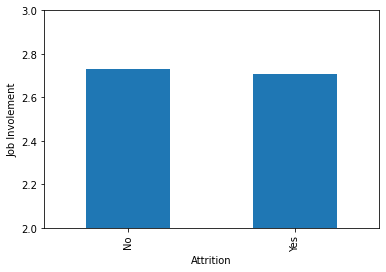

In [18]:
# Job involement has little impact on attrition.

companies_df[["attrition", "job_involvement"]].groupby("attrition").mean().plot(kind="bar", legend=False, ylabel="Job Involement", xlabel="Attrition", ylim=[2,3])
companies_df[["attrition", "job_involvement"]].groupby("attrition").mean()

,environment_satisfaction
attrition,
No,2.774024
Yes,2.466284


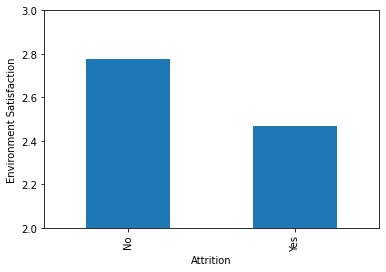

In [19]:
# Environment satisfaction seems to have a significant impact on attrition rate.

companies_df[["attrition", "environment_satisfaction"]].groupby("attrition").mean().plot(kind="bar", legend=False, ylabel="Environment Satisfaction", xlabel="Attrition", ylim=[2,3])
companies_df[["attrition", "environment_satisfaction"]].groupby("attrition").mean()

,performance_rating
attrition,
No,3.150097
Yes,3.175036


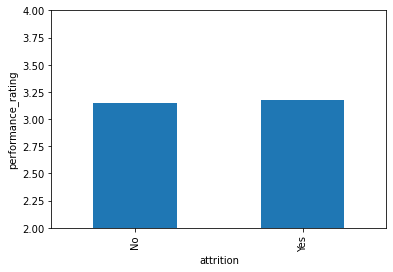

In [20]:
# It also seems that attrition has little to no impact on performance rating.

companies_df[["attrition", "performance_rating"]].groupby("attrition").mean().plot(kind="bar", legend=False, ylabel="performance_rating", ylim=[2,4])
companies_df[["attrition", "performance_rating"]].groupby("attrition").mean()

<AxesSubplot:ylabel='Attrition'>

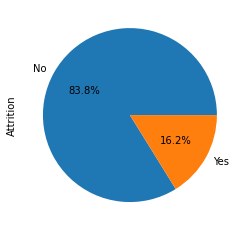

In [21]:
# Only 16% of employees in the dataset have quit.

companies_df[["attrition", "job_satisfaction"]].groupby("attrition").count().plot(kind="pie", y="job_satisfaction", ylabel="Attrition", autopct='%1.1f%%', legend=False)

<AxesSubplot:xlabel='Number of Companies Worked', ylabel='Average Job Satisfaction'>

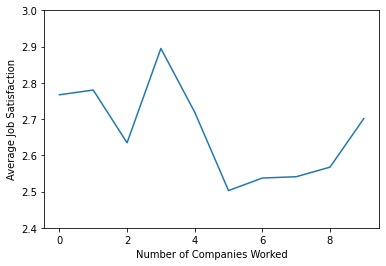

In [22]:
# Breaking down job satisfaction based on number of companies worked it seems that employees that have
# worked at 4 or less companies tend to be more satisfied with their jobs.

companies_df[["job_satisfaction", "num_companies_worked"]].groupby("num_companies_worked").mean().plot(kind="line", legend=False, ylim=[2.4,3], xlabel="Number of Companies Worked", ylabel="Average Job Satisfaction")

<AxesSubplot:xlabel='Number of Companies Worked', ylabel='Work/Life Balance'>

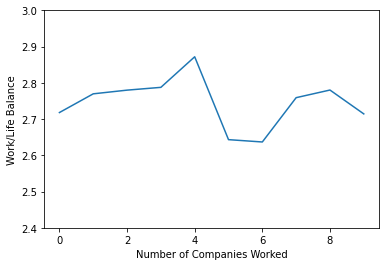

In [23]:
# It appears that employees that have worked at more than 4 companies report worse work/life balance than those
# who work for 4 or less.

companies_df[["work_life_balance", "num_companies_worked"]].groupby("num_companies_worked").mean().plot(kind="line", legend=False, ylim=[2.4,3], xlabel="Number of Companies Worked", ylabel="Work/Life Balance")

<AxesSubplot:xlabel='Number of Companies Worked', ylabel='Job Performance'>

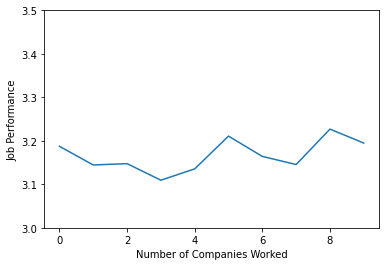

In [24]:
# Job permance rating seems to be faily regular accross the board.

companies_df[["performance_rating", "num_companies_worked"]].groupby("num_companies_worked").mean().plot(kind="line", legend=False, ylim=[3,3.5], xlabel="Number of Companies Worked", ylabel="Job Performance")

<AxesSubplot:ylabel='Number of Companies Worked'>

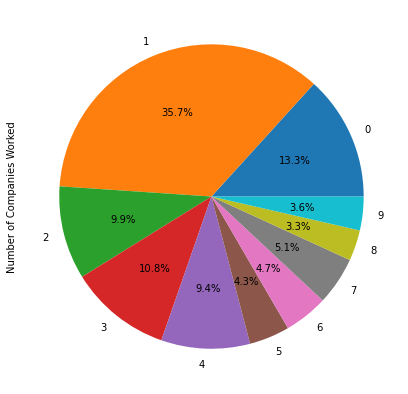

In [25]:
# A plurality of employees have only worked for 1 previous employeer, with most employees working for 2 or less.

companies_df[["job_satisfaction", "num_companies_worked"]].groupby("num_companies_worked").count().plot(kind="pie", y='job_satisfaction', autopct='%1.1f%%', legend=False, ylabel="Number of Companies Worked", figsize=[7,7])

,percent_salary_hike
attrition,
No,15.159236
Yes,15.494978


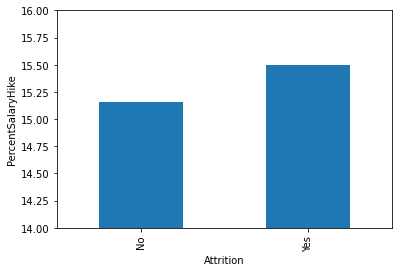

In [26]:
# Employees who leave receive larger salary hikes than those who stay.

companies_df[["attrition", "percent_salary_hike"]].groupby("attrition").mean().plot(kind="bar", legend=False, ylabel="PercentSalaryHike", xlabel="Attrition", ylim=[14,16])
companies_df[["attrition", "percent_salary_hike"]].groupby("attrition").mean()

,percent_salary_hike
performance_rating,
3,14.003293
4,21.855422


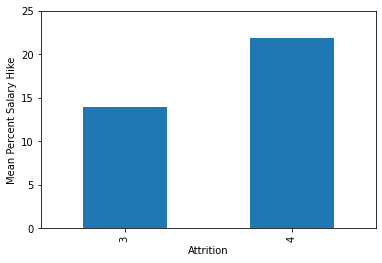

In [27]:
# Employees with higher performance ratings receive higher salary hikes.

companies_df[["performance_rating", "percent_salary_hike"]].groupby("performance_rating").mean().plot(kind="bar", legend=False, ylabel="Mean Percent Salary Hike", xlabel="Attrition", ylim=[0,25])
companies_df[["performance_rating", "percent_salary_hike"]].groupby("performance_rating").mean()

,percent_salary_hike
job_satisfaction,
1,14.969303
2,15.283636
3,15.115385
4,15.420659


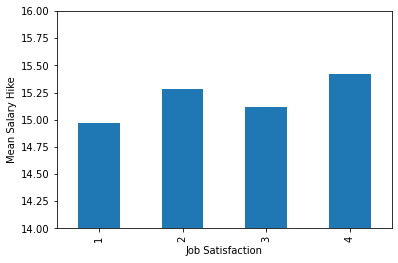

In [28]:
# Employees with higer salary increases also have higher job satisfaction.

companies_df[["job_satisfaction", "percent_salary_hike"]].groupby("job_satisfaction").mean().plot(kind="bar", legend=False, ylabel="Mean Salary Hike", xlabel="Job Satisfaction", ylim=[14,16])
companies_df[["job_satisfaction", "percent_salary_hike"]].groupby("job_satisfaction").mean()

# Load 

In [29]:
# With transformation and analysis completed we can load this into a sql database for later.

from postgres_login import username, password, connection

connection_string = connection_string = f"{username}:{password}@localhost:{connection}/project2"
engine = create_engine(f'postgresql://{connection_string}')

In [30]:
# When loading we raise an error if the dataset already exists and ask the user for confirmation if they would like 
# to replace the existing dataset.

try:
    companies_df.to_sql(name="company_data", con=engine, if_exists="fail", index=True)
    print("Dataset loaded to SQL")
except:
    answer = input("Table already exists, do you want to replace?(y/n): ").lower()
    if answer[0] == "y":
        companies_df.to_sql(name="company_data", con=engine, if_exists="replace", index=True)
        print("Dataset loaded to SQL")
    else:
        print("SQL load canceled")

Table already exists, do you want to replace?(y/n): y
Dataset loaded to SQL
